# Import Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
import scikitplot as skplt

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [2]:
import utils as ut

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [4]:
df_combined = pd.read_csv("data/exported/df_combined.csv", index_col = 0)
df_yeast_combined = pd.read_csv("data/exported/df_yeast_combined.csv", index_col = 0)

In [5]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category",
                                  "modified_status_rolling_max":"object"})
df_combined = df_combined.astype({"ref_number":"object"})

In [6]:
df_yeast_combined = df_yeast_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_combined = df_yeast_combined.astype({"ref_number":"object"})

# train test split

In [7]:
# manual train test split according to ref_num to preserve sequence sequence identity
# maybe do it according to read_num to increase variability?

final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
#train_ref = ["ref_0000","ref_0001","ref_0002"]
#test_ref = ["ref_0003"]

In [8]:
seed = 7

## combined

In [9]:
X_finaltest_combined = df_combined[df_combined["ref_number"].isin(final_ref)]
y_finaltest_combined = X_finaltest_combined.pop("modified_status")
X_val_combined = df_combined[df_combined["ref_number"].isin(val_ref)]
y_val_combined = X_val_combined.pop("modified_status")
#X_train_combined = df_combined[df_combined["ref_number"].isin(train_ref)]
#y_train_combined = X_train_combined.pop("modified_status")
#X_test_combined = df_combined[df_combined["ref_number"].isin(test_ref)]
#y_test_combined = X_test_combined.pop("modified_status")

In [10]:
# prepare list of numeric and categorical features to feed into column transformer
numeric_features_combined = list(X_finaltest_combined .columns[X_finaltest_combined .dtypes ==  "float"])

In [11]:
numeric_features_combined

['dwell_time_median',
 'dwell_time_min',
 'dwell_time_max',
 'median_value_median',
 'median_value_min',
 'median_value_max',
 'dwell_time_rolling_median',
 'median_value_rolling_median',
 'dwell_time_rolling_min',
 'median_value_rolling_min',
 'dwell_time_diff_to_median',
 'median_value_diff_to_median']

In [12]:
cat_features_combined = list(X_finaltest_combined.columns[X_finaltest_combined.dtypes ==  "category"])

In [13]:
cat_features_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [14]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_combined = SimpleImputer(strategy="median")
scaler1_combined = StandardScaler()
numeric_transformer_combined = make_pipeline(imputer1_combined,scaler1_combined)


imputer2_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_combined = make_pipeline(imputer2_combined,encoder_combined)

preprocessor_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined),
        ('cat', cat_transformer_combined, cat_features_combined)
    ])

### limitation preprocessor combined

In [15]:
numeric_features_combined_limited = ["dwell_time_median","dwell_time_rolling_min","dwell_time_diff_to_median"]

In [16]:
# only select 3 values (most important ones)


preprocessor_combined_limited = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_combined, numeric_features_combined_limited)
    ])

# supervised combined

In [17]:
# apporach using an aggregated dataset to eliminate measurement fluctuation

In [18]:
# prepare empty dataframes for result collection
model_selection_results = pd.DataFrame()
yeast_prediction_results = pd.DataFrame()

In [19]:
# cv by hand produces 4 fits singling each of the four remaining dna strands out each time, to provide
# realistic cross validation
labels = X_finaltest_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

## baseline

In [20]:
# baseline model with all zeros, as data is rather imbalanced
y_pred = np.zeros(len(X_val_combined))

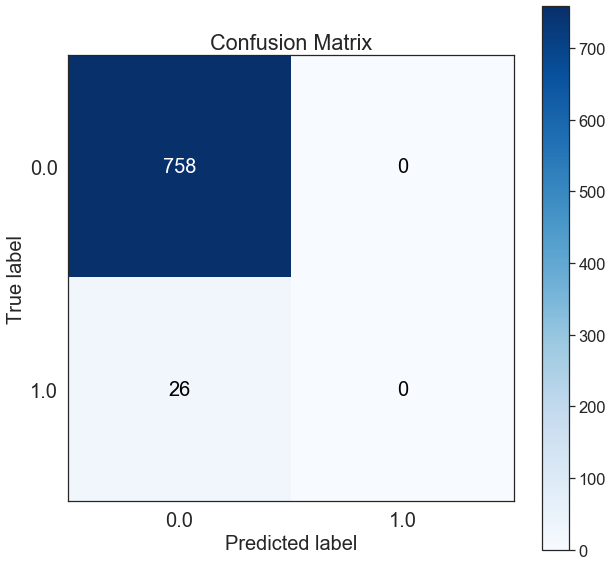

In [21]:
skplt.metrics.plot_confusion_matrix(y_val_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [22]:
print(classification_report(y_val_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       758
         1.0       0.00      0.00      0.00        26

    accuracy                           0.97       784
   macro avg       0.48      0.50      0.49       784
weighted avg       0.93      0.97      0.95       784



C:\Users\neomo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## classical ml models

In [23]:
# full featureset of aggregated dataset, 100% recall and minimal false positives

### model selection

In [24]:
# first model selection on whole dataset using model selector class (found in utilities.py)
sel_c = ut.ModelSelector(preprocessor_combined, instance_name = "Combined Dataframe")

In [25]:
sel_c.select_model(X_finaltest_combined, y_finaltest_combined, True)

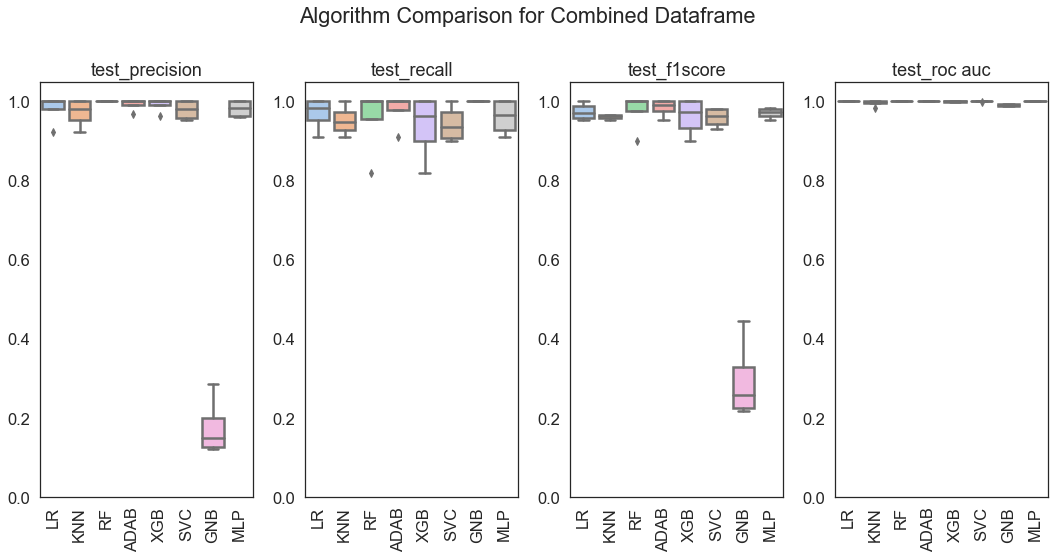

In [26]:
sel_c.plot_selection()

In [27]:
model_selection_results = pd.concat([model_selection_results,sel_c.get_scores()], axis=0)

### xgb gridsearch

In [28]:
#xgb hast good f1 score and is time efficient , so this one is used in grid search, parameter in grid represent best ones found
param_grid_xgb = {'xgbclassifier__max_depth':[5],
                 'xgbclassifier__learning_rate':[0.3],
                 'xgbclassifier__n_estimators':[150],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [29]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = make_pipeline(preprocessor_combined,xgb_clf)

In [30]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs = -1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 150}


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.93      1.00      0.96        26

    accuracy                           1.00       784
   macro avg       0.96      1.00      0.98       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 74 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref

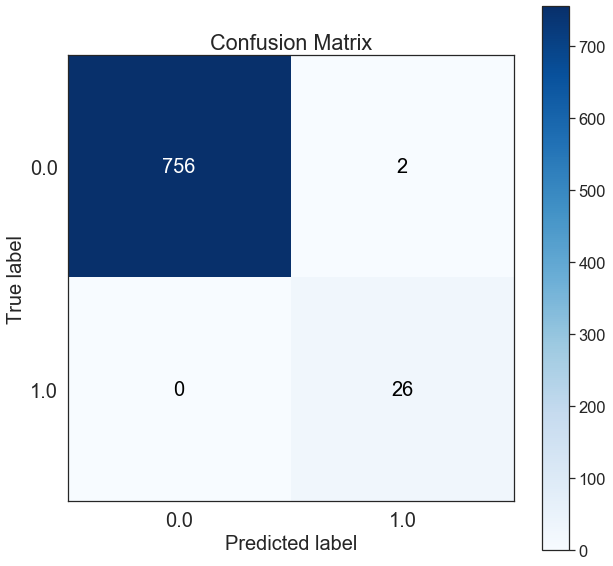

In [31]:
modified_ratio_combined = ut.evaluation(grid_xgb, X_val_combined, y_val_combined)

### feature importances

In [32]:
# in aggregated dataset base information is not as important -> base information seems to be artificial

In [33]:

xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.3,
                        max_depth= 5, n_estimators = 150)

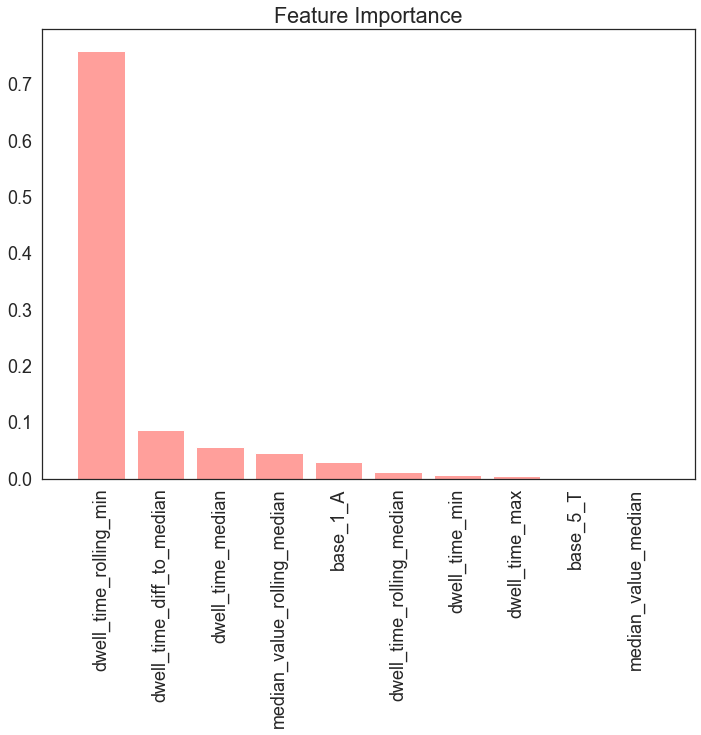

In [34]:
ut.feature_importances(xgb, preprocessor_combined, X_finaltest_combined, y_finaltest_combined)

### yeast dataset

In [35]:
df_yeast_temp = df_yeast_combined.copy()

In [36]:
df_yeast_temp.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

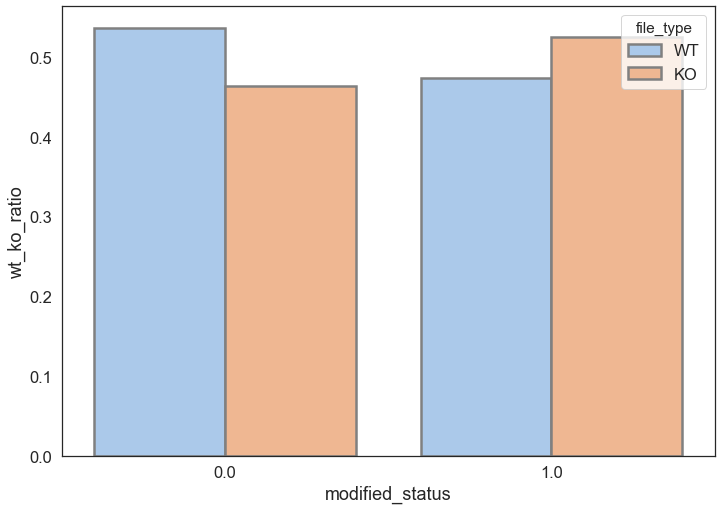

In [37]:
temp = ut.yeast_prediction(preprocessor_combined, X_finaltest_combined, 
                 y_finaltest_combined, df_yeast_temp, xgb, "Combined")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

## classical ml models with oversampling

In [38]:
# full feature set combined dataframe oversampling = 100% recall and precision

In [39]:
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


### model selection

In [40]:
sel_c_os = ut.ModelSelector(preprocessor_combined, smotet, instance_name = "Combined Dataframe and Oversampling")

sel_c_os.select_model(X_finaltest_combined, y_finaltest_combined, True)

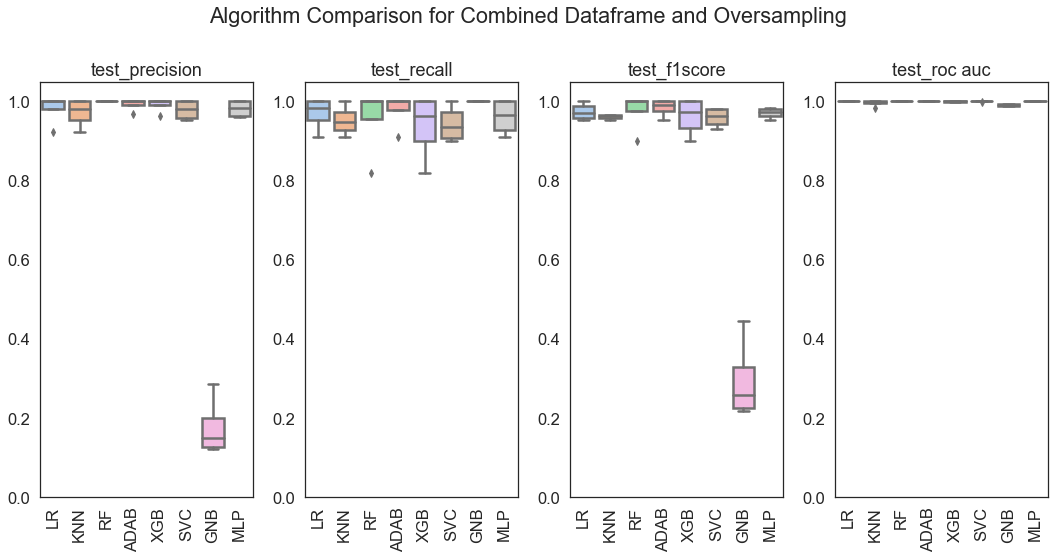

In [41]:
sel_c_os.plot_selection()

In [42]:
model_selection_results = pd.concat([model_selection_results,sel_c_os.get_scores()], axis=0)

### xgb gridsearch

In [43]:
param_grid_xgb = {'xgbclassifier__max_depth':[5],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[100],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [44]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_combined),("smt",smotet),("xgbclassifier",xgb_clf)])

In [45]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.96      1.00      0.98        26

    accuracy                           1.00       784
   macro avg       0.98      1.00      0.99       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref_pos 179 is :50.0
Ratio of modified Reads for re

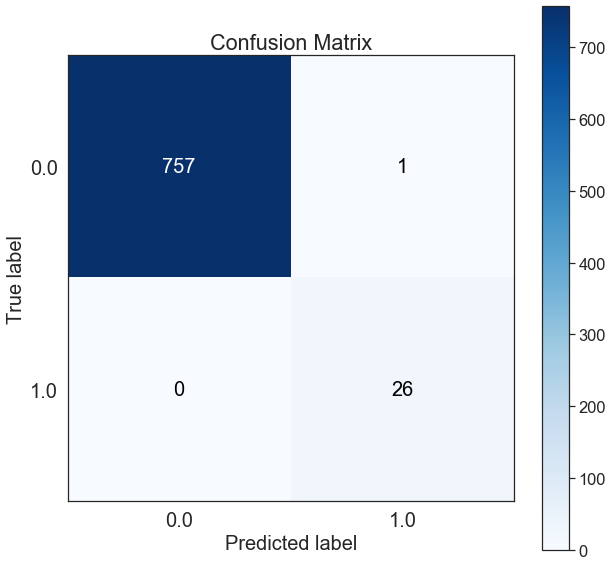

In [46]:
modified_ratio_combined_os = ut.evaluation(grid_xgb, X_val_combined, y_val_combined)

### yeast dataset

In [47]:
df_yeast_temp = df_yeast_combined.copy()

In [48]:
df_yeast_temp.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

In [49]:
xgb_clf = XGBClassifier(n_jobs=-1,random_state=seed, max_depth=5, n_estimators=100, gamma=0, learning_rate=0.1 )
xgb = Pipeline([("smt",smotet),("xgbclassifier",xgb_clf)])

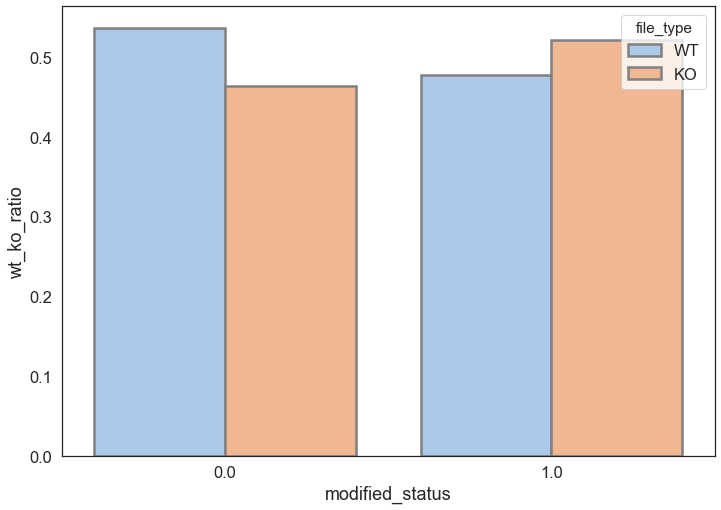

In [50]:
temp = ut.yeast_prediction(preprocessor_combined, X_finaltest_combined, 
                 y_finaltest_combined, df_yeast_temp, xgb, "Combined Oversampling")

yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

## classical models limited

### model selection

In [51]:
sel_c_limited = ut.ModelSelector(preprocessor_combined_limited, instance_name = "Combined Dataframe Limited")

In [52]:
sel_c_limited.select_model(X_finaltest_combined, y_finaltest_combined, True)

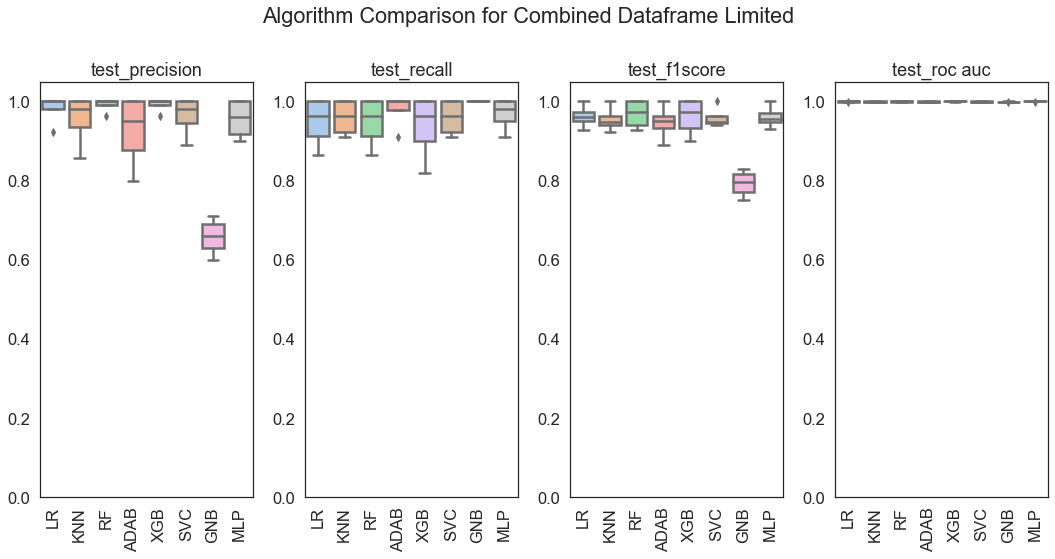

In [53]:
sel_c_limited.plot_selection()

In [54]:
model_selection_results = pd.concat([model_selection_results,sel_c_limited.get_scores()], axis=0)

### xgb gridsearch

In [55]:
# in a limited setting xgboost has also the best overall performance, stacking did not seem useful, as overall performance is
# already very good
param_grid_xgb = {'xgbclassifier__max_depth':[5,10,15],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[10,50,100],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0,0.001,0.1]}

In [56]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_combined_limited),("xgbclassifier",xgb_clf)])

In [57]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  77 out of 108 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    0.9s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.93      1.00      0.96        26

    accuracy                           1.00       784
   macro avg       0.96      1.00      0.98       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 74 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref

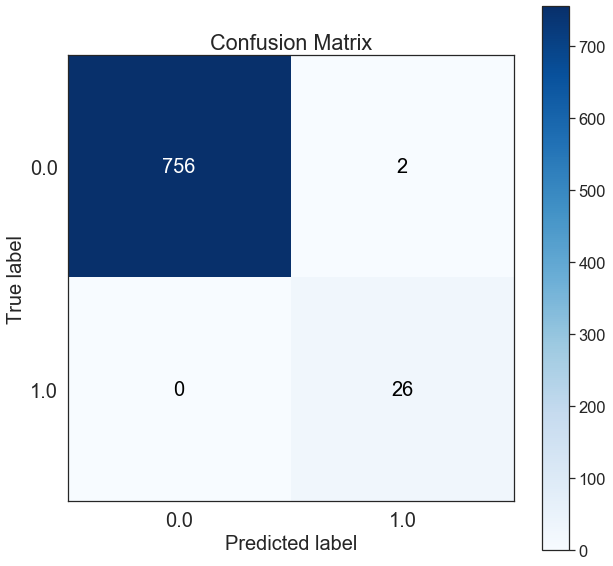

In [58]:
modified_ratio_combined_os = ut.evaluation(grid_xgb, X_val_combined, y_val_combined)

### feature importances

In [59]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.1,
                        max_depth= 5, n_estimators = 100)

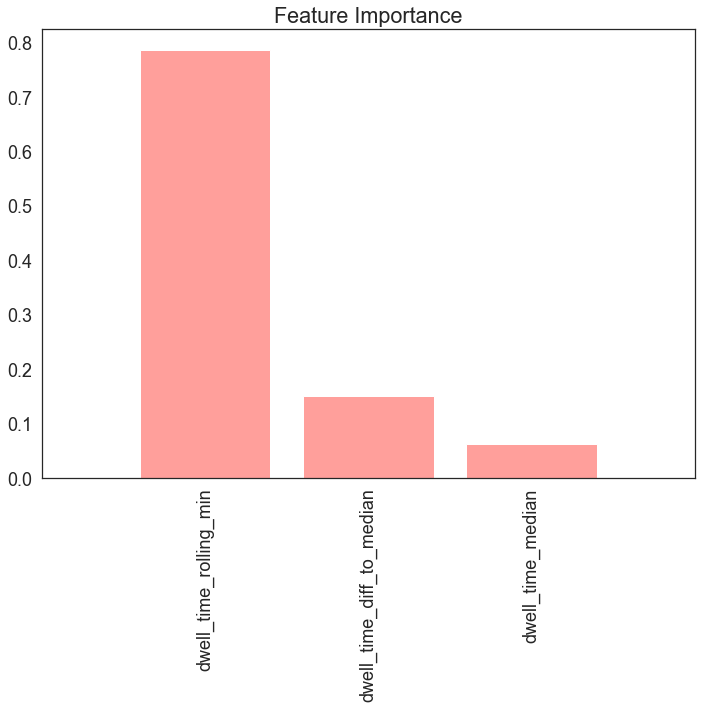

In [60]:
ut.feature_importances(xgb, preprocessor_combined_limited, X_finaltest_combined, y_finaltest_combined, 
                    custom_feature_state=True, custom_feature_list = numeric_features_combined_limited)

### yeast dataset

In [61]:
df_yeast_temp = df_yeast_combined.copy()

In [62]:
df_yeast_temp.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

In [63]:
xgb = XGBClassifier(n_jobs=-1,random_state=seed, max_depth=5, n_estimators=100, gamma=0, learning_rate=0.1 )


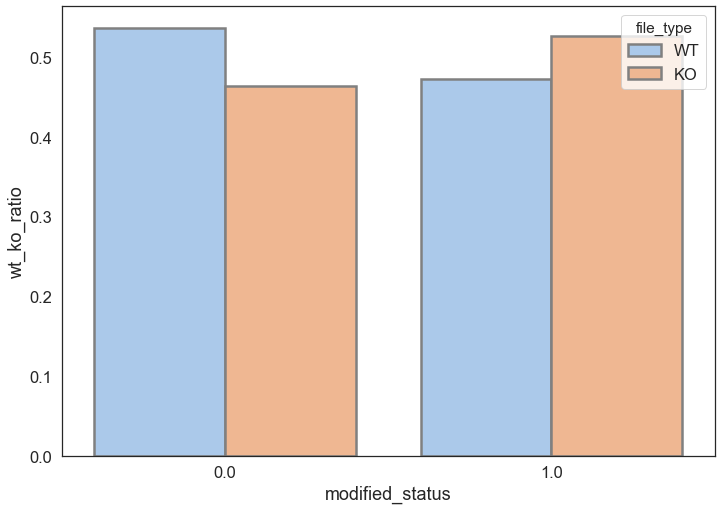

In [64]:
temp = ut.yeast_prediction(preprocessor_combined_limited, X_finaltest_combined, 
                 y_finaltest_combined, df_yeast_temp, xgb, "Combined Limited")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

### yeast data prediction export

In [65]:
# export yeast data set with predicted status for visualization purposes
y_pred = xgb.predict(preprocessor_combined_limited.fit_transform(df_yeast_temp))

In [66]:
df_yeast_temp["predicted_status"] = y_pred

In [67]:
df_yeast_temp.to_csv("data/exported/df_yeast_combined_predicted.csv")

## combined limited with oversampling

In [68]:
# combine oversampling with limitation approach, does not improve yeast prediction (slightly worse)

### model selection

In [69]:
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


In [70]:
sel_clos = ut.ModelSelector(preprocessor_combined_limited, smotet, instance_name = "Combined Dataframe Limited and Oversampling")
sel_clos.select_model(X_finaltest_combined, y_finaltest_combined, True)

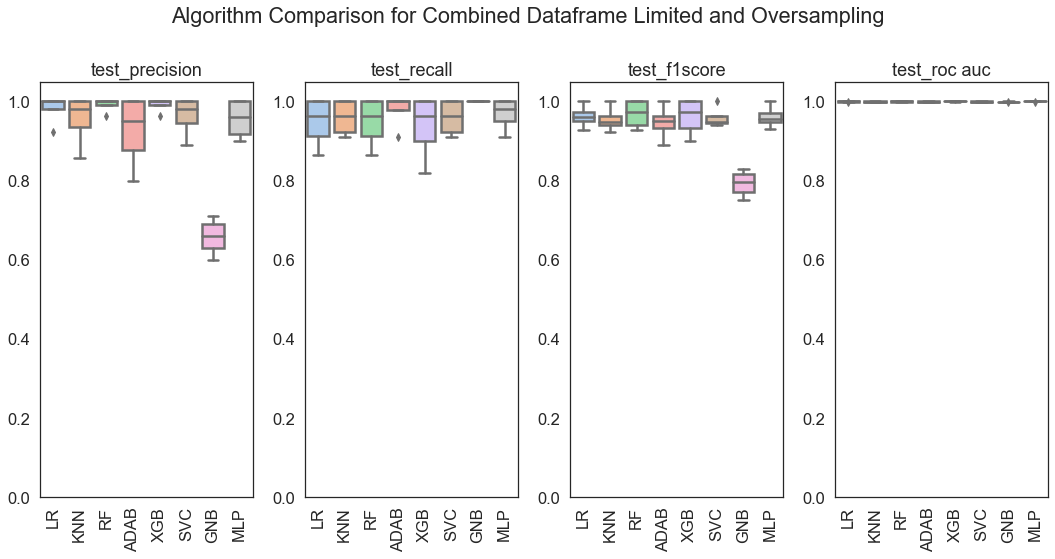

In [71]:
sel_clos.plot_selection()

In [72]:
model_selection_results = pd.concat([model_selection_results,sel_clos.get_scores()], axis=0)

### xgb gridsearch

In [73]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.75],
                 'xgbclassifier__n_estimators':[3000],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [74]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_combined_limited),("smt",smotet),("xgbclassifier",xgb_clf)])

In [75]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs = -1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_combined, y_finaltest_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.8s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.75, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 3000}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       758
         1.0       0.93      1.00      0.96        26

    accuracy                           1.00       784
   macro avg       0.96      1.00      0.98       784
weighted avg       1.00      1.00      1.00       784

------------------------------
Ratio of modified Reads for ref_pos 15 is :50.0
Ratio of modified Reads for ref_pos 26 is :50.0
Ratio of modified Reads for ref_pos 43 is :50.0
Ratio of modified Reads for ref_pos 58 is :50.0
Ratio of modified Reads for ref_pos 65 is :50.0
Ratio of modified Reads for ref_pos 74 is :50.0
Ratio of modified Reads for ref_pos 75 is :50.0
Ratio of modified Reads for ref_pos 81 is :50.0
Ratio of modified Reads for ref_pos 104 is :50.0
Ratio of modified Reads for ref_pos 123 is :50.0
Ratio of modified Reads for ref_pos 163 is :50.0
Ratio of modified Reads for ref_pos 169 is :50.0
Ratio of modified Reads for ref

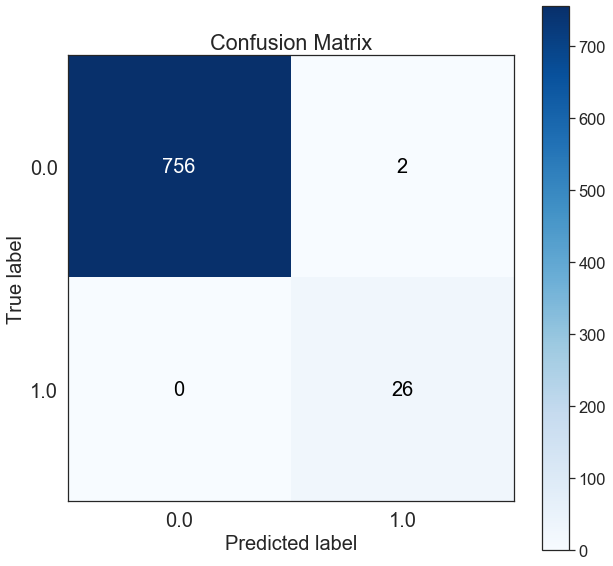

In [76]:
modified_ratio_clos = ut.evaluation(grid_xgb, X_val_combined, y_val_combined, thresh=0)

### yeast dataset

In [77]:
df_yeast_temp = df_yeast_combined.copy()

In [78]:
df_yeast_temp.rename(columns = {"dwell_time":"dwell_time_median", "median_value":"median_value_median"}, inplace=True)

In [79]:
xgb_clf = XGBClassifier(n_jobs=-1,random_state=seed, max_depth=1, n_estimators=3000, gamma=0, learning_rate=0.75 )
xgb = Pipeline([("smt",smotet),("xgbclassifier",xgb_clf)])

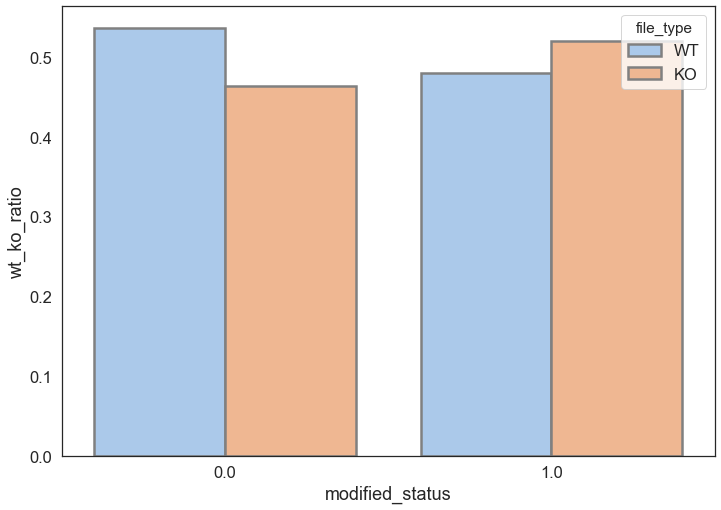

In [80]:
temp = ut.yeast_prediction(preprocessor_combined_limited, X_finaltest_combined, 
                 y_finaltest_combined, df_yeast_temp, xgb, "Combined Limited with Oversamppling")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

In [81]:
yeastpred = yeast_prediction_results.reset_index()

In [82]:
yeastpred[(yeastpred.file_type == "KO") & (yeastpred.modified_status == 1.0)]

,Model,modified_status,file_type,wt_ko_ratio
2,Combined,1.0,KO,0.525720
6,Combined Oversampling,1.0,KO,0.522027
10,Combined Limited,1.0,KO,0.526887
14,Combined Limited with Oversamppling,1.0,KO,0.519876


In [83]:
yeastpred.iloc[yeastpred[(yeastpred.file_type == "KO") & (yeastpred.modified_status == 1.0)].wt_ko_ratio.idxmax()]

Model              Combined Limited
modified_status                   1
file_type                        KO
wt_ko_ratio                0.526887
Name: 10, dtype: object

In [84]:
model_selection_results

test_result
instance_name                               test           model             
Combined Dataframe                          test_precision RF        1.000000
                                                           ADAB      0.991935
                                                           XGB       0.990741
                                            test_recall    GNB       1.000000
                                                           ADAB      0.977273
                                                           LR        0.968939
                                            test_f1score   ADAB      0.983997
                                                           RF        0.975000
                                                           LR        0.973858
                                            test_roc auc   RF        1.000000
                                                           MLP       1.000000
                                                           LR        1.000000
Combined Dataframe and Oversampling         test_precision RF        1.000000
                                                           ADAB      0.991935
                                                           XGB       0.990741
                                            test_recall    GNB       1.000000
                                                           ADAB      0.977273
                                                           LR        0.968939
                                            test_f1score   ADAB      0.983997
                                                           RF        0.975000
                                                           LR        0.973858
                                            test_roc auc   RF        1.000000
                                                           MLP       1.000000
                                                           LR        1.000000
Combined Dataframe Limited                  test_precision XGB       0.990741
                                                           RF        0.990741
                                                           LR        0.980769
                                            test_recall    GNB       1.000000
                                                           ADAB      0.977273
                                                           MLP       0.968344
                                            test_f1score   RF        0.968071
                                                           LR        0.962448
                                                           XGB       0.961364
                                            test_roc auc   MLP       0.999953
                                                           XGB       0.999902
                                                           RF        0.999872
Combined Dataframe Limited and Oversampling test_precision XGB       0.990741
                                                           RF        0.990741
                                                           LR        0.980769
                                            test_recall    GNB       1.000000
                                                           ADAB      0.977273
                                                           MLP       0.968344
                                            test_f1score   RF        0.968071
                                                           LR        0.962448
                                                           XGB       0.961364
                                            test_roc auc   MLP       0.999953
                                                           XGB       0.999902
                                                           RF        0.999872

In [85]:
yeast_prediction_results

wt_ko_ratio
Model                               modified_status file_type             
Combined                            0.0             KO            0.463286
                                                    WT            0.536714
                                    1.0             KO            0.525720
                                                    WT            0.474280
Combined Oversampling               0.0             KO            0.463301
                                                    WT            0.536699
                                    1.0             KO            0.522027
                                                    WT            0.477973
Combined Limited                    0.0             KO            0.463271
                                                    WT            0.536729
                                    1.0             KO            0.526887
                                                    WT            0.473113
Combined Limited with Oversamppling 0.0             KO            0.463293
                                                    WT            0.536707
                                    1.0             KO            0.519876
                                                    WT            0.480124